# **Generative Modeling with a Variational Autoencoder (VAE)**

This notebook demonstrates how to build, train, and use a Variational Autoencoder (VAE) model from the Bonsai library to generate new images of handwritten digits.

*This colab demonstrates the VAE implementation from the [Bonsai library](https://github.com/jax-ml/bonsai).*

## **1. Setup and Imports**
First, we'll install the necessary libraries and import our modules.

In [ ]:
!pip install -q git+https://github.com/jax-ml/bonsai@main
!pip install -q optax tensorflow-datasets matplotlib
!pip install tensorflow -q
!pip install --upgrade flax -q

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import tensorflow_datasets as tfds
from flax import nnx
import tensorflow as tf
import os
os.chdir("/home/neo/Downloads/CODE_Other_Models/bonsai/bonsai/models/vae")
sys.path.append('/home/neo/Downloads/CODE_Other_Models/bonsai')


import sys
from pathlib import Path

# Add the bonsai root to Python path for imports
bonsai_root = Path.home()
sys.path.insert(0, str(bonsai_root))

# Now you can import from the bonsai package without changing directories
from bonsai.models.vae import modeling as vae_lib
from bonsai.models.vae import params as params_lib

## **2. Load and Preprocess Data**

We'll use the classic MNIST dataset of handwritten digits. We need to normalize the pixel values to the `[0, 1]` range, which is important for the VAE's reconstruction loss.

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from flax import nnx
import orbax.checkpoint as ocp
from pathlib import Path
import sys

bonsai_root = Path.home()
if str(bonsai_root) not in sys.path:
    sys.path.insert(0, str(bonsai_root))
from bonsai.models.vae import modeling as vae_lib
from bonsai.models.vae import params as params_lib


# --- Load 10 images from the MNIST test set ---
print("Loading 10 MNIST test images...")
ds = tfds.load('mnist', split='test', as_supervised=True)
images_list = []
labels_list = []

for image, label in ds.take(10):
    # Preprocess: convert to float32 and normalize
    single_image = tf.cast(image, tf.float32) / 255.0
    images_list.append(single_image.numpy())
    labels_list.append(label.numpy())

# Stack the images into a single batch
image_batch = jnp.stack(images_list, axis=0)

print(f"✅ Loaded a batch of 10 images with shape: {image_batch.shape}")

Loading 10 MNIST test images...


I0000 00:00:1758719157.283911  161743 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4741 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-09-24 10:05:57.456527: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


✅ Loaded a batch of 10 images with shape: (10, 28, 28, 1)


## **3.Define Model**

Here we'll configure and instantiate our VAE model.

In [7]:
# --- Create a randomly initialized model ---
print("\nCreating a new model with random weights...")

rngs = nnx.Rngs(params=0, sample=1)
model = params_lib.create_model(cfg=config, rngs=rngs) # This is all you need!

print("New model created successfully!")


Creating a new model with random weights...
New model created successfully!


## **4. Reconstruct the Input**

This function performs a full forward pass: image -> encode -> sample -> decode

In [8]:
# --- Define the JIT-compiled reconstruction function ---
@jax.jit
def reconstruct(model: vae_lib.VAE, batch: jax.Array, sample_key: jax.Array):
    """Encodes and decodes an image batch using the trained VAE."""
    # The model now outputs logits
    reconstruction_logits_flat, _, _ = model(batch, sample_key=sample_key)

    reconstructed_probs_flat = jax.nn.sigmoid(reconstruction_logits_flat)
    
    # Reshape the flat output back to the original image shape
    return reconstructed_probs_flat.reshape(batch.shape)

# Get a random key for the reparameterization trick
sample_key = rngs.sample()

print("\nRunning inference to reconstruct images...")
reconstructed_images = reconstruct(model, image_batch, sample_key)
print("Reconstruction complete.")


Running inference to reconstruct images...
Reconstruction complete.


## **5. Show Reconstruction**

We'll create a single, JIT-compiled function to perform one step of training. This function computes the loss, calculates gradients, and applies them to update the model's parameters.

Displaying results...


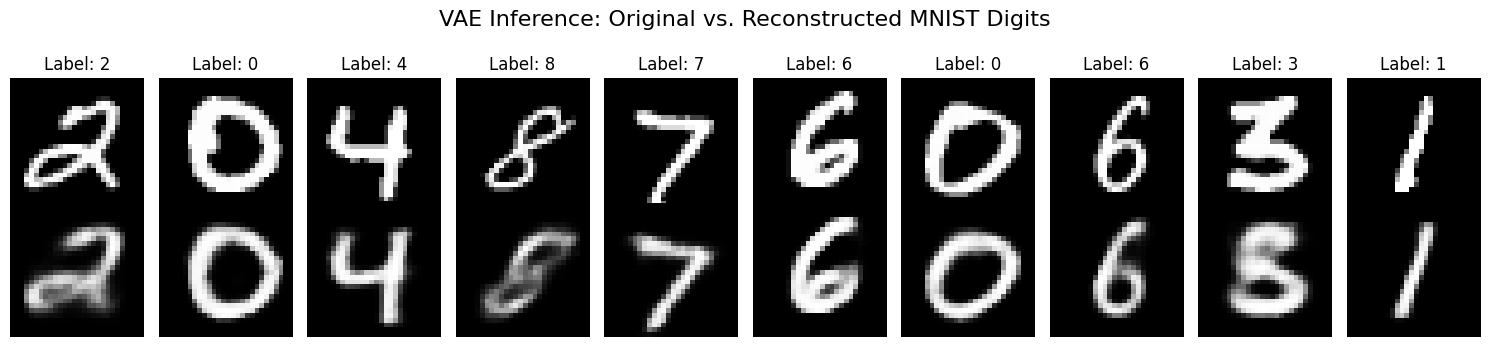

In [6]:
# --- Plot the results ---
print("Displaying results...")
fig, axes = plt.subplots(2, 10, figsize=(15, 3.5))

for i in range(10):
    # Plot original images on the first row
    axes[0, i].imshow(image_batch[i, ..., 0], cmap='gray')
    axes[0, i].set_title(f"Label: {labels_list[i]}")
    axes[0, i].axis('off')

    # Plot reconstructed images on the second row
    axes[1, i].imshow(reconstructed_images[i, ..., 0], cmap='gray')
    axes[1, i].axis('off')

# Add row labels
axes[0, 0].set_ylabel("Original", fontsize=12, labelpad=15)
axes[1, 0].set_ylabel("Reconstructed", fontsize=12, labelpad=15)


plt.suptitle("VAE Inference: Original vs. Reconstructed MNIST Digits", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## **Conclusion**

This notebook demonstrated the complete workflow for the Bonsai VAE model:

1.  **Instantiated the VAE model** with a specific configuration.
2.  **Loaded and preprocessed** the MNIST dataset.
3.  **Defined a loss function** and a JIT-compiled training step.
4.  **Trained the model** to reconstruct digits and structure its latent space.
5.  **Generated new, plausible handwritten digits** by sampling from the latent space.